In [17]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from math import pi

# 1. ROBUST PATH CONFIGURATION
# Matches the structure of your uploaded files
BASE_DIR = Path("results_attained") 
if not BASE_DIR.exists():
    # Fallback for notebook location
    BASE_DIR = Path("../results_attained")

OUTPUT_DIR = Path("Results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 2. IEEE PUBLICATION STYLE
sns.set_theme(style="whitegrid", context="paper", font_scale=1.6) # Increased font size
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']

# 3. CONSISTENT COLORS & MARKERS
# CLIP=Blue, LoRA=Red, Frozen=Green (Distinct & Colorblind-safe)
COLORS = {"CLIP": "#0072B2", "CLIP_LORA": "#D55E00", "FROZEN": "#009E73"}
MARKERS = {"CLIP": "^", "CLIP_LORA": "^", "FROZEN": "^"} # Uniform Triangles

print(f"✓ Configuration loaded. Saving plots to: {OUTPUT_DIR.resolve()}")

✓ Configuration loaded. Saving plots to: /sda/usama/production_code/visual_testing/Results


In [19]:
def load_all_data():
    records = []
    model_stats = {}
    class_reports = {}
    
    # Define models to look for
    models_to_check = ["CLIP", "CLIP_LORA", "FROZEN"]

    for model in models_to_check:
        model_path = BASE_DIR / model
        if not model_path.exists():
            continue
            
        # Load File Helper
        def load_json(filename):
            p = model_path / filename
            if p.exists():
                with open(p) as f: return json.load(f)
            return {}

        # Load Critical Files
        eval_data = load_json("evaluation_results.json")
        lat_data = load_json("latency.json")
        mem_data = load_json("memory.json")
        param_data = load_json("parameters.json")
        cls_data = load_json("classification_report.json")
        
        if not eval_data: continue

        # 1. Extract Metrics
        throughput = lat_data.get("throughput_samples_per_second", 0)
        peak_mem = mem_data.get("inference_peak_gpu_mb", 0)
        params_m = (param_data.get("trainable_parameters", 0) + param_data.get("frozen_parameters", 0)) / 1e6

        # 2. Linear Probe Data
        lp_accs = []
        if "linear_probe" in eval_data:
            for ds, metrics in eval_data["linear_probe"].items():
                acc = metrics.get("accuracy", 0)
                lp_accs.append(acc)
                records.append({
                    "Model": model, "Task": "Linear Probe", "Dataset": ds.upper(),
                    "Value": acc, "Throughput": throughput
                })
        
        # 3. Zero-Shot Data
        if "zero_shot" in eval_data:
            for ds, metrics in eval_data["zero_shot"].items():
                records.append({
                    "Model": model, "Task": "Zero-Shot", "Dataset": ds.upper(),
                    "Value": metrics.get("top1", 0)
                })

        # 4. Few-Shot Data
        if "few_shot" in eval_data:
            for ds, shots in eval_data["few_shot"].items():
                for k, v in shots.items():
                    records.append({
                        "Model": model, "Task": "Few-Shot", "Dataset": ds.upper(),
                        "Shots": int(k.split('-')[0]), "Accuracy": v
                    })

        # 5. Store Class Reports & Stats
        if cls_data: class_reports[model] = cls_data
        
        model_stats[model] = {
            "Throughput": throughput,
            "Memory": peak_mem,
            "Params_M": params_m,
            "Avg_Acc": np.mean(lp_accs) if lp_accs else 0
        }

    return pd.DataFrame(records), model_stats, class_reports

df, model_stats, class_reports = load_all_data()
print(f"✓ Data Loaded: {len(df)} records found across {len(model_stats)} models.")

✓ Data Loaded: 100 records found across 3 models.


/tmp/ipykernel_43154/869367810.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x="Model", y="Throughput", palette=COLORS, edgecolor="black")


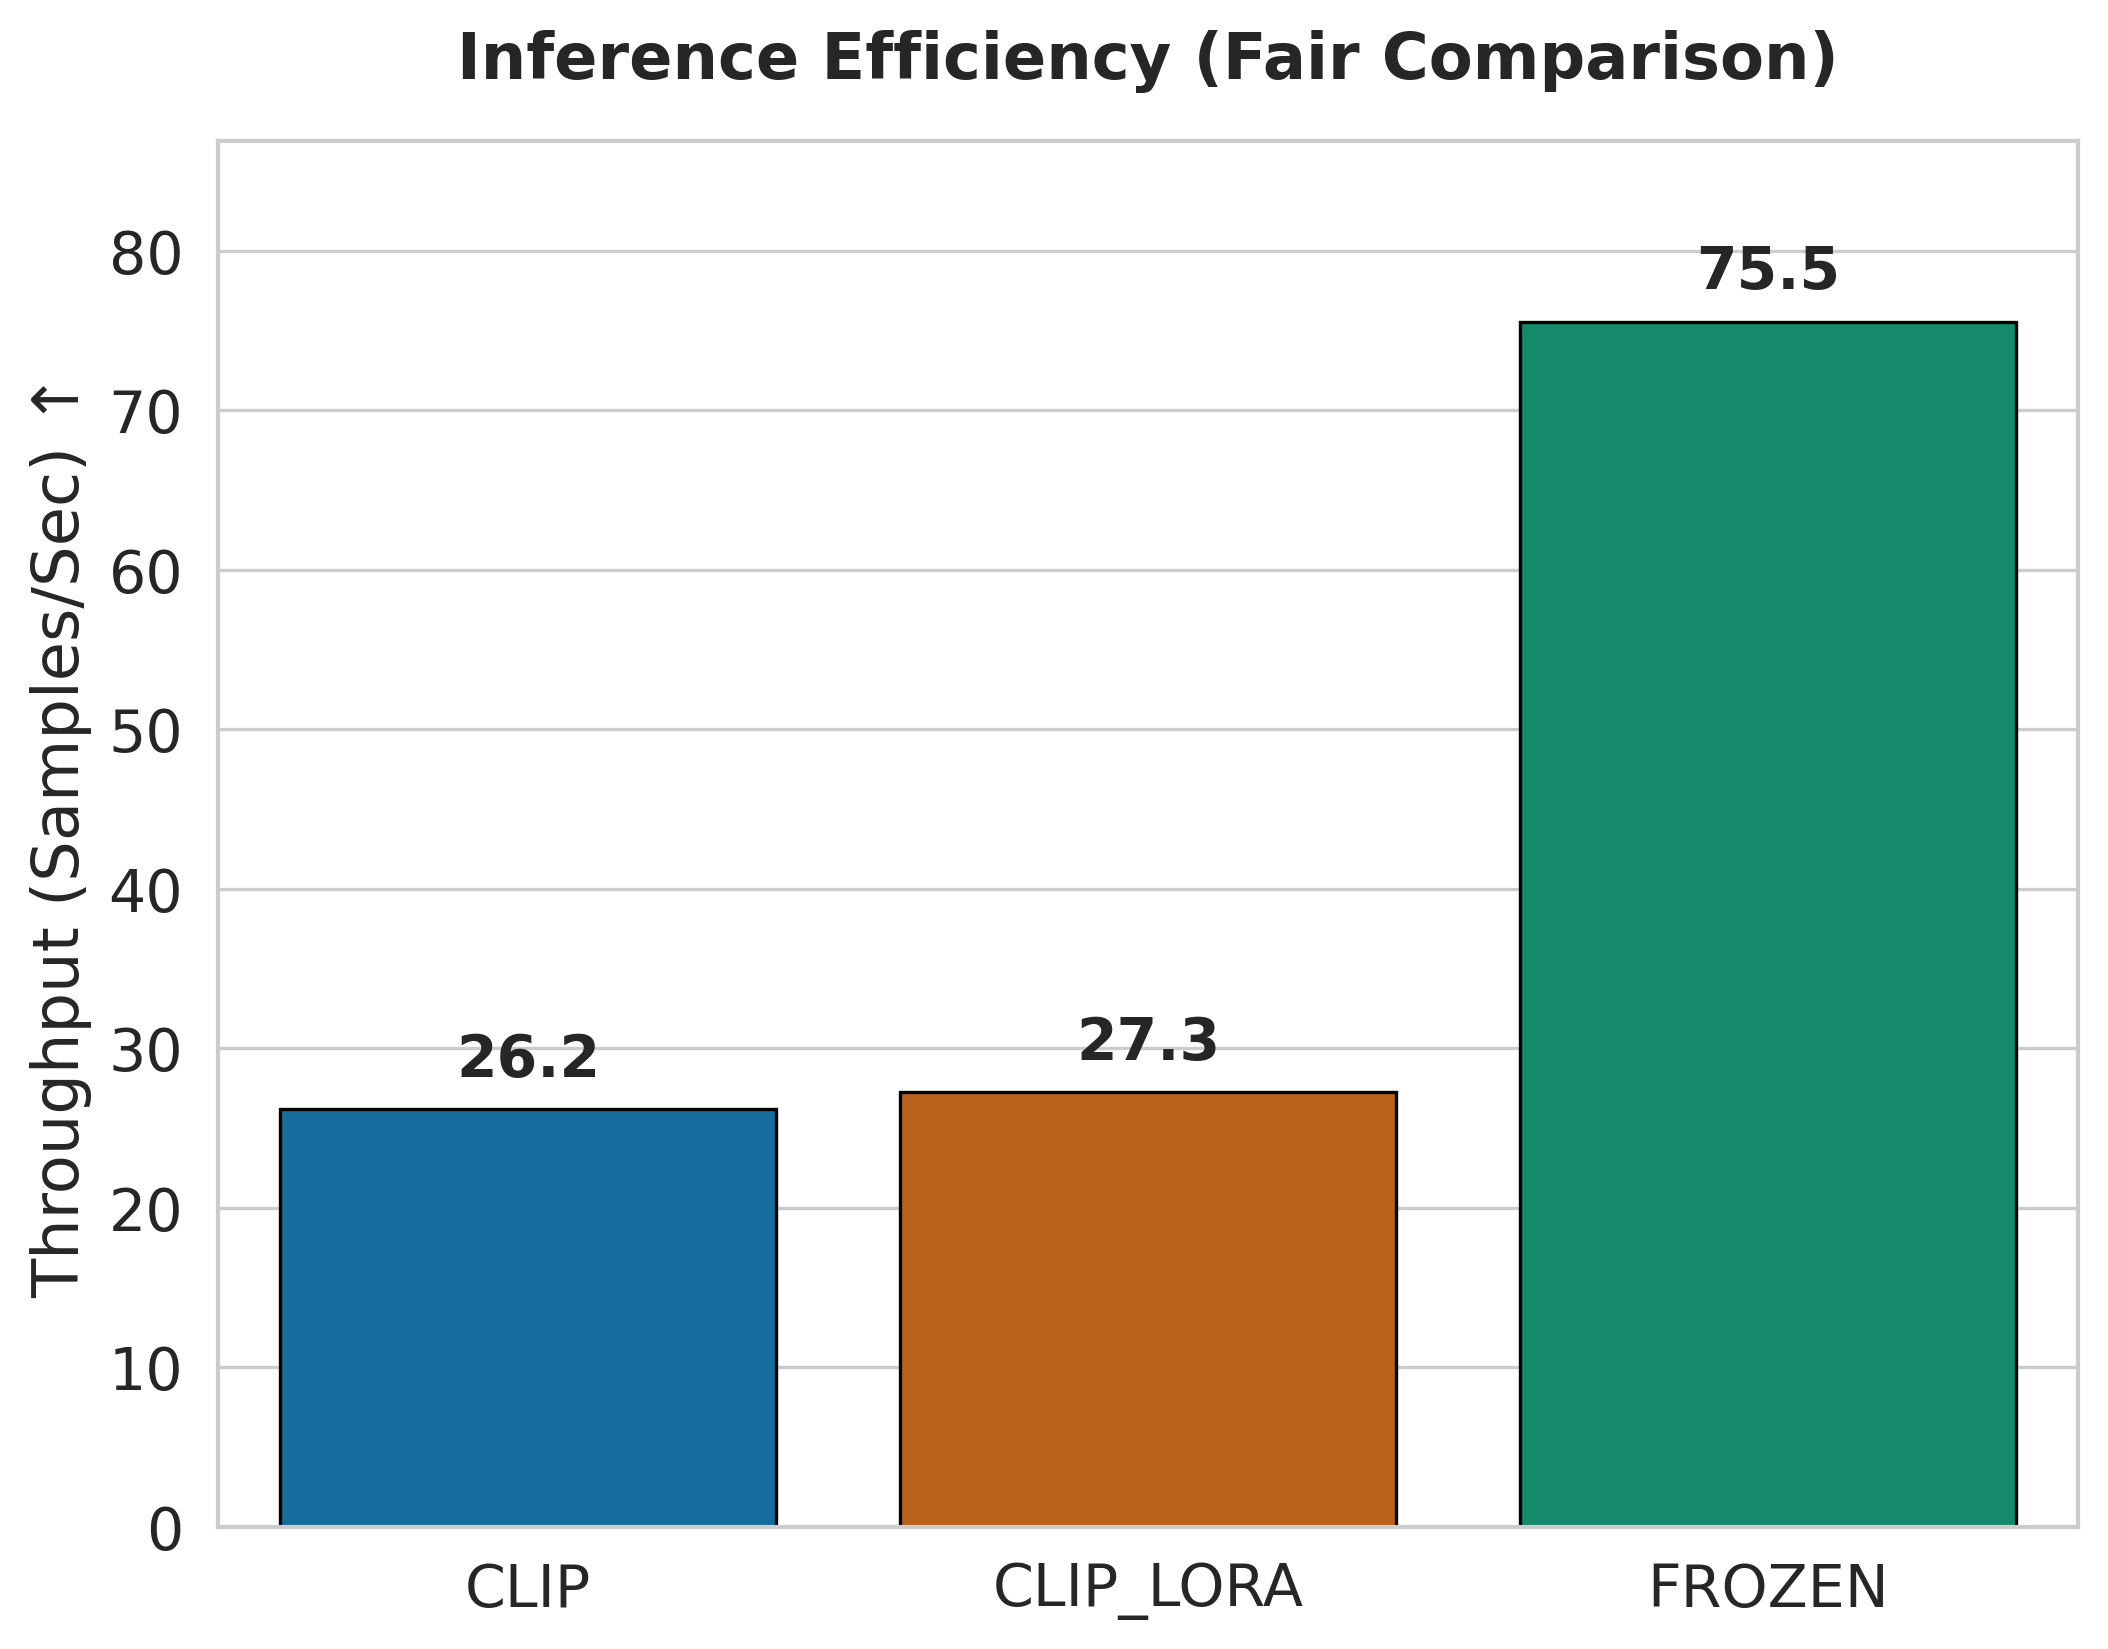

In [20]:
def plot_efficiency():
    if not model_stats: return
    data = pd.DataFrame(model_stats).T.reset_index().rename(columns={"index": "Model"})
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=data, x="Model", y="Throughput", palette=COLORS, edgecolor="black")
    
    # Clear Text Labels
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}', 
                   (p.get_x() + p.get_width() / 2., height), 
                   ha='center', va='bottom', fontsize=14, fontweight='bold', 
                   xytext=(0, 5), textcoords='offset points')

    plt.title("Inference Efficiency (Fair Comparison)", fontweight='bold', pad=15)
    plt.ylabel("Throughput (Samples/Sec) ↑")
    plt.xlabel("")
    plt.ylim(0, data["Throughput"].max() * 1.15) # Add headroom for text
    
    plt.savefig(OUTPUT_DIR / "Fig1_Efficiency.png")
    plt.show()

plot_efficiency()

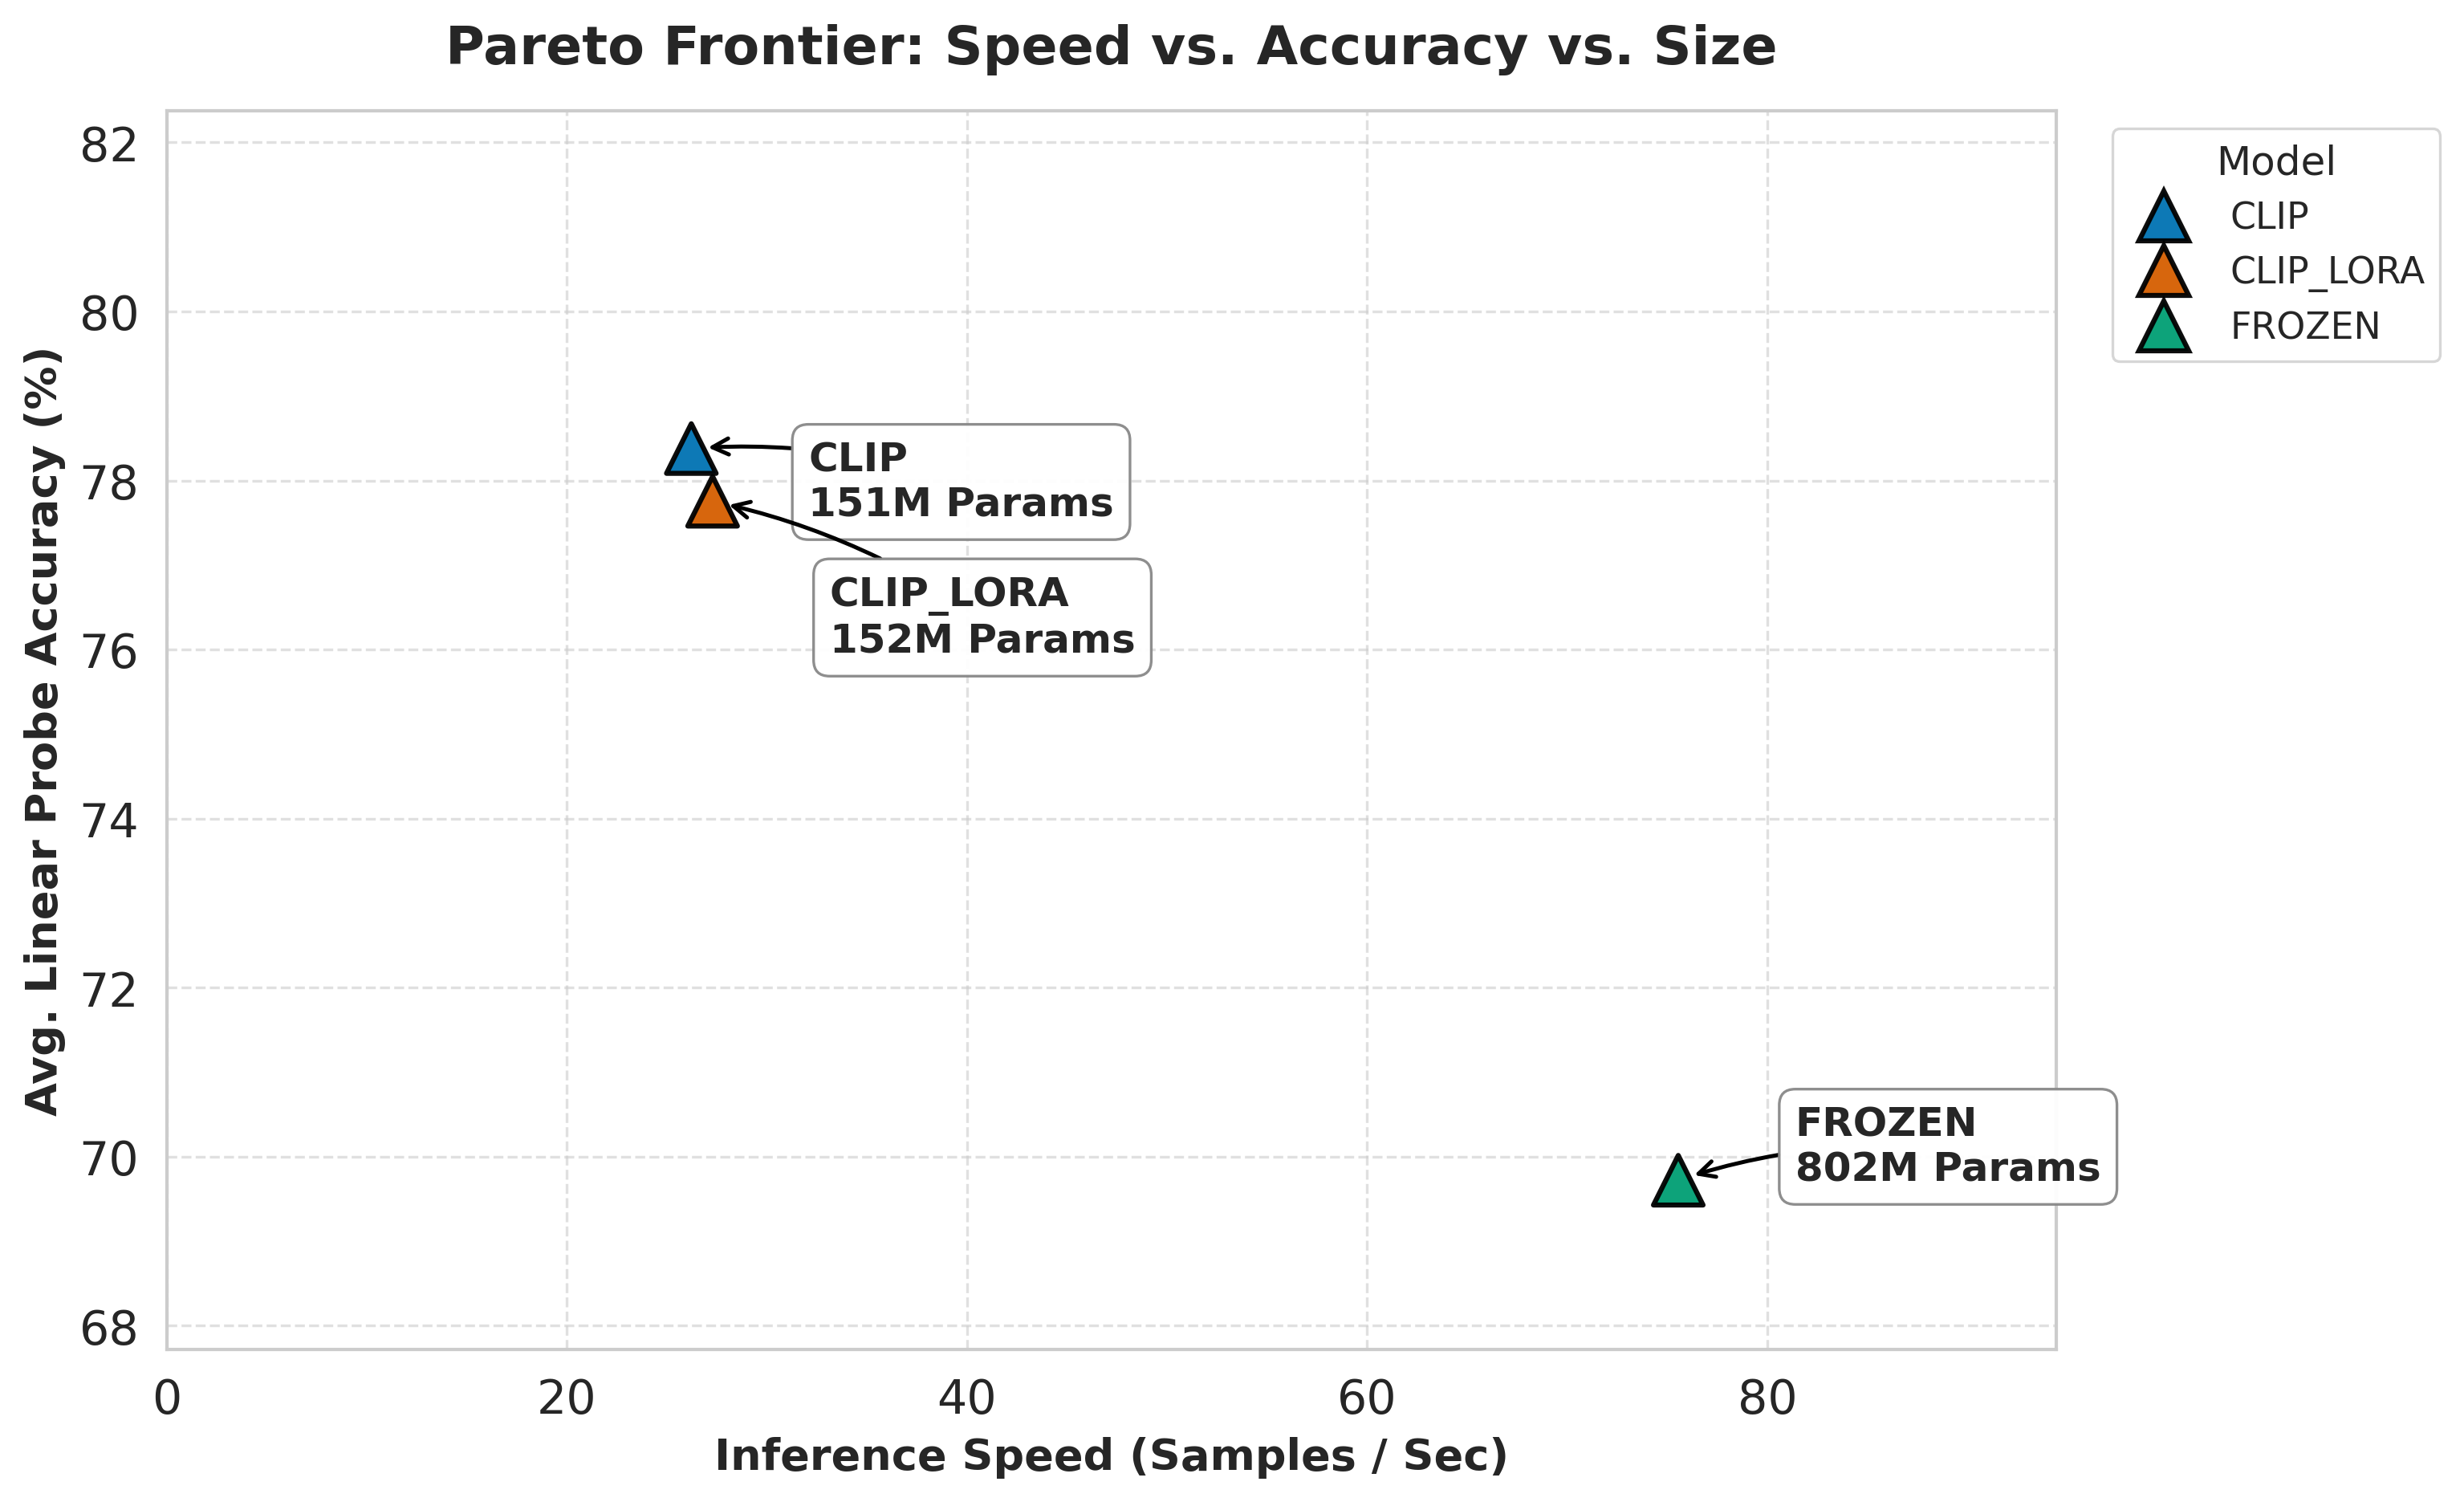

In [28]:
def plot_pareto_final():
    if not model_stats:
        return

    data = (
        pd.DataFrame(model_stats)
        .T.reset_index()
        .rename(columns={"index": "Model"})
    )

    plt.figure(figsize=(10.5, 6.5))

    # 1. CLEAN SCATTER (no size legend)
    ax = sns.scatterplot(
        data=data,
        x="Throughput",
        y="Avg_Acc",
        hue="Model",
        style="Model",
        palette=COLORS,
        markers=MARKERS,
        s=220,                      # fixed marker size
        edgecolor="black",
        linewidth=1.5,
        alpha=0.95,
        legend=True
    )

    # 2. SMART, NON-OVERLAPPING LABELS
    offsets = {
        "CLIP": (35, -10),
        "CLIP_LORA": (35, -35),
        "FROZEN": (35, 10),
    }

    for _, row in data.iterrows():
        dx, dy = offsets[row["Model"]]

        ax.annotate(
            f"{row['Model']}\n{int(row['Params_M'])}M Params",
            xy=(row["Throughput"], row["Avg_Acc"]),
            xytext=(dx, dy),
            textcoords="offset points",
            ha="left",
            va="center",
            fontsize=12,
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                edgecolor="#888",
                alpha=0.95,
                boxstyle="round,pad=0.4",
            ),
            arrowprops=dict(
                arrowstyle="->",
                lw=1.2,
                color="black",
                shrinkA=0,
                shrinkB=5,
                connectionstyle="arc3,rad=0.1",
            ),
        )

    # 3. LEGEND — MODEL ONLY
    ax.legend(
        title="Model",
        title_fontsize=12,
        fontsize=11,
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=True,
    )

    # 4. AXES, TITLE, GRID
    ax.set_title(
        "Pareto Frontier: Speed vs. Accuracy vs. Size",
        fontsize=16,
        fontweight="bold",
        pad=14,
    )
    ax.set_xlabel("Inference Speed (Samples / Sec)", fontsize=13, fontweight="bold")
    ax.set_ylabel("Avg. Linear Probe Accuracy (%)", fontsize=13, fontweight="bold")

    ax.set_xlim(0, data["Throughput"].max() * 1.25)
    ax.set_ylim(
        data["Avg_Acc"].min() - 2,
        data["Avg_Acc"].max() + 4,
    )

    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(
        OUTPUT_DIR / "Fig2_Pareto_Frontier_Final.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


plot_pareto_final()

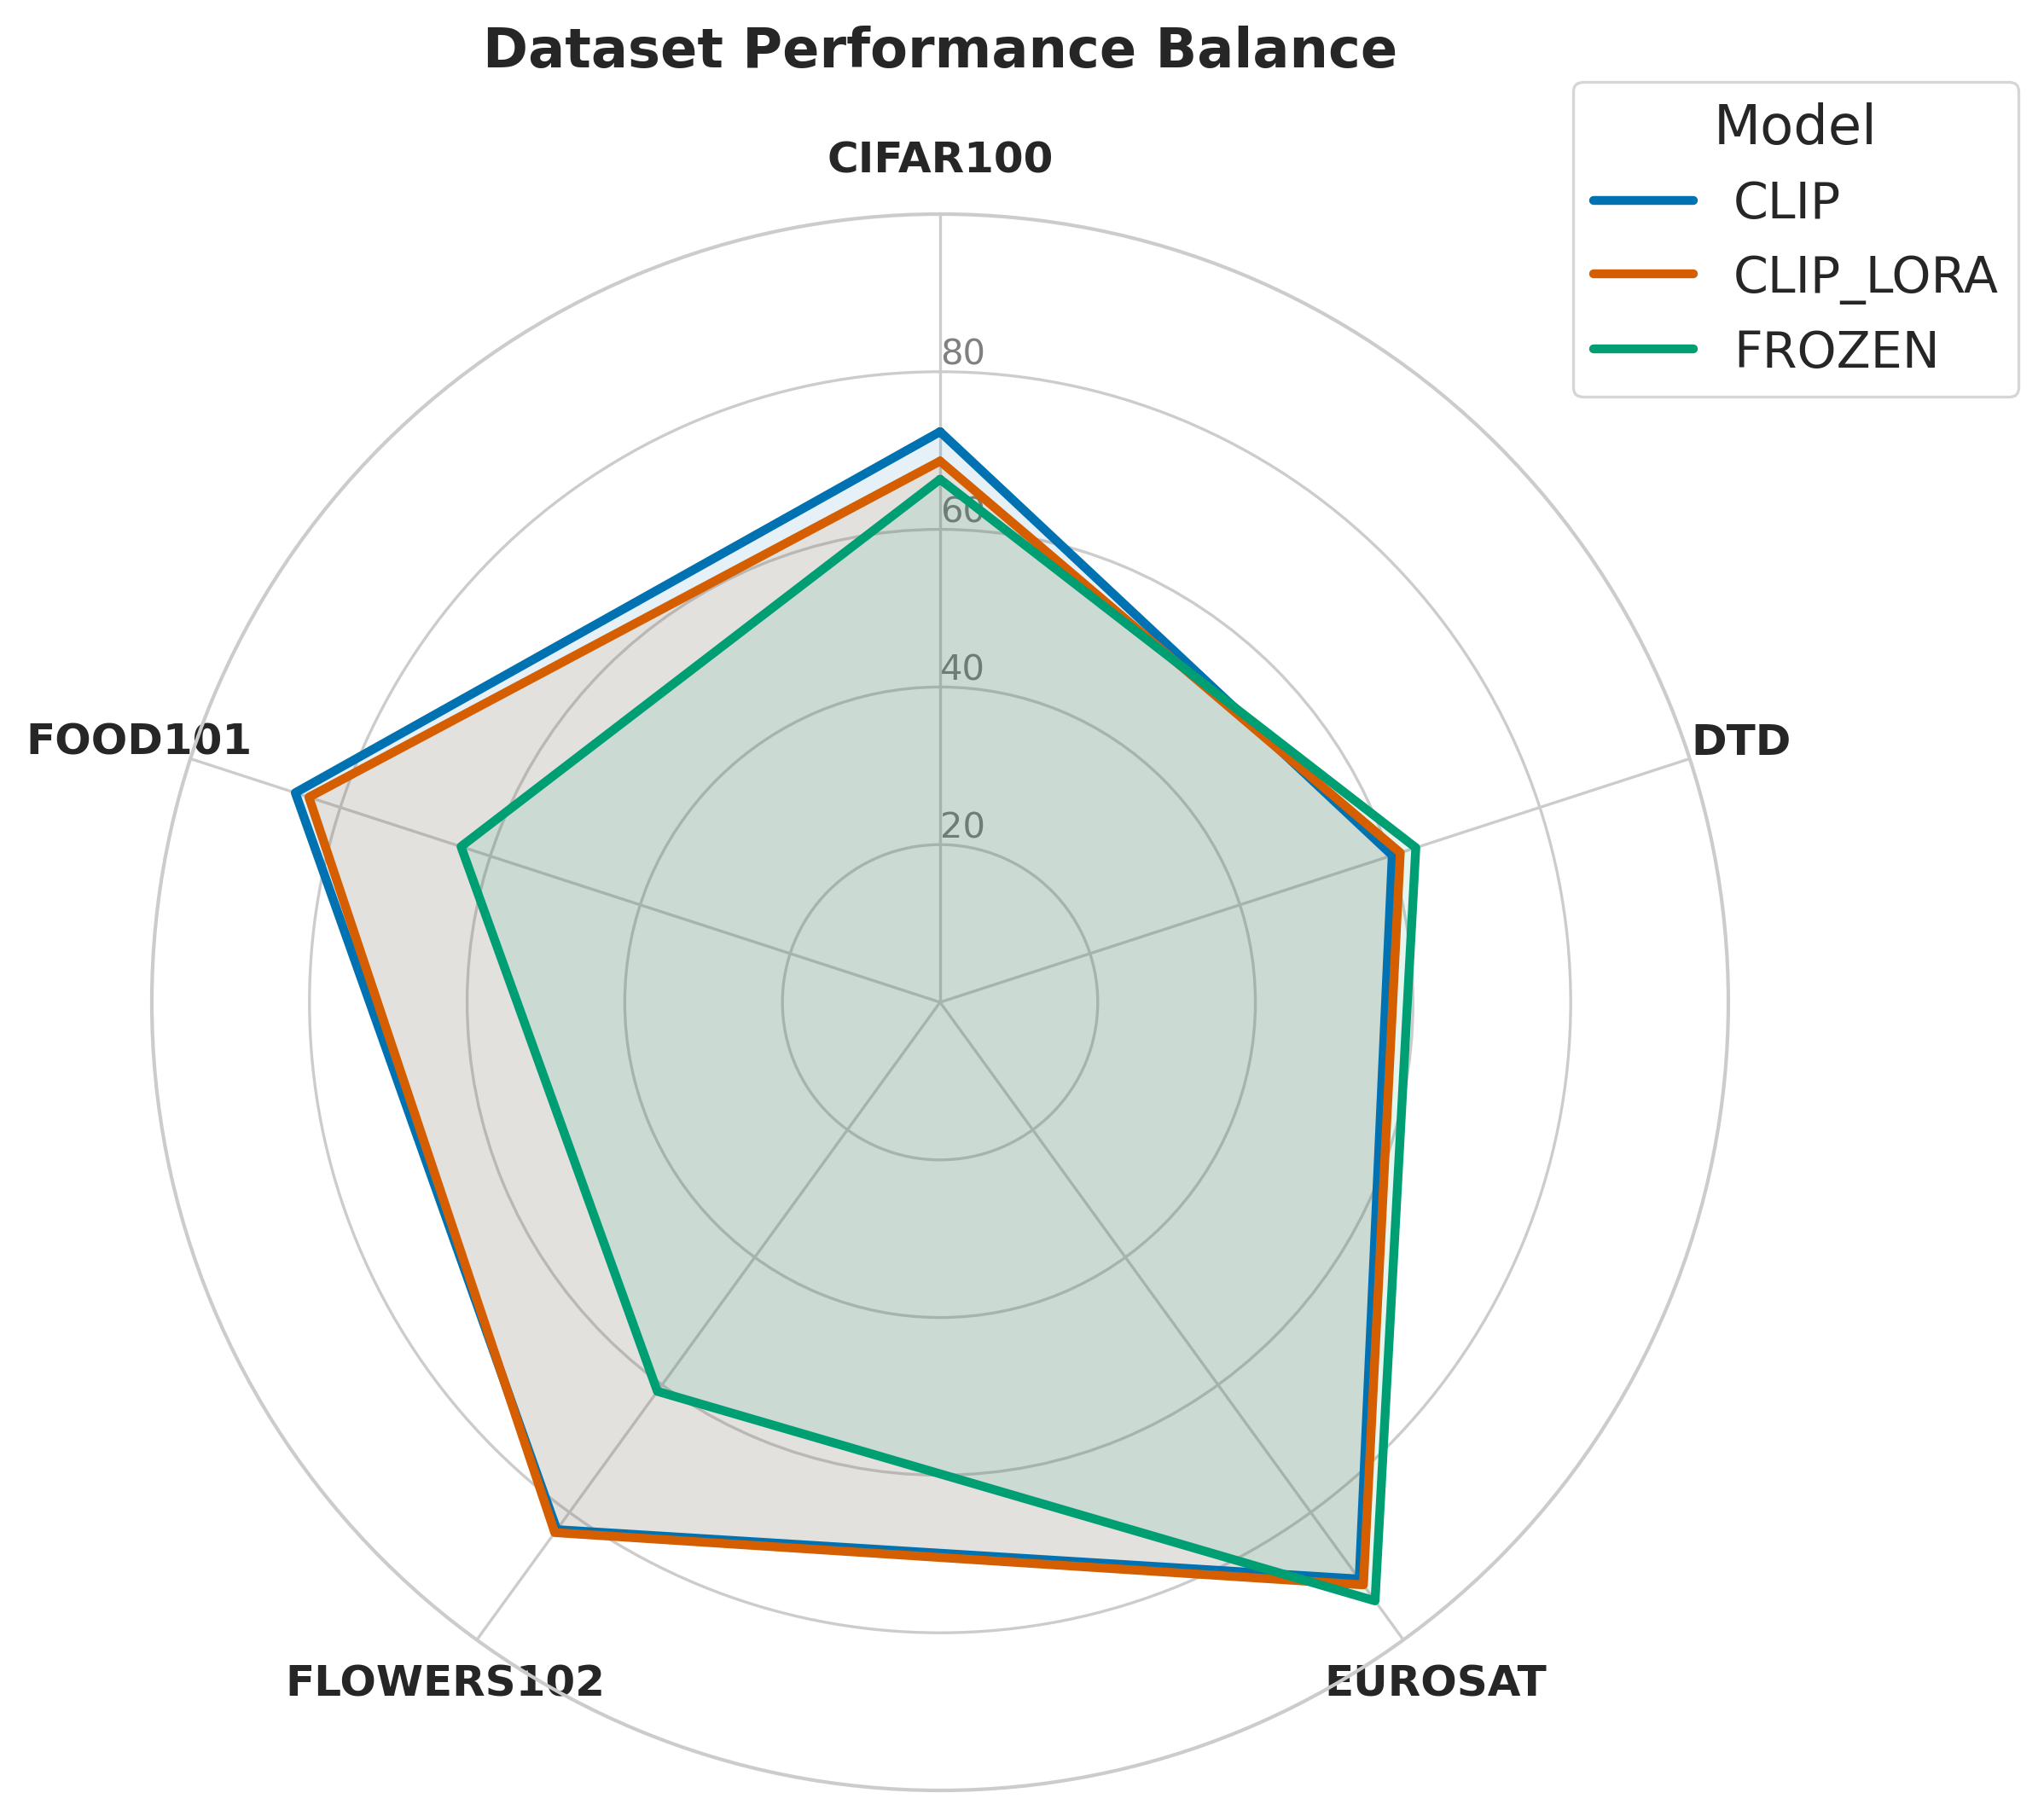

In [22]:
def plot_radar():
    lp_df = df[df["Task"] == "Linear Probe"]
    if lp_df.empty: return

    # Pivot Data
    pivot = lp_df.pivot(index="Model", columns="Dataset", values="Value")
    labels = list(pivot.columns)
    num_vars = len(labels)
    
    # Compute Angles
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1] # Close loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for model in pivot.index:
        values = pivot.loc[model].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=model, color=COLORS[model])
        ax.fill(angles, values, color=COLORS[model], alpha=0.1)
    
    # Style
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks([20, 40, 60, 80], ["20", "40", "60", "80"], color="grey", size=10)
    plt.ylim(0, 100)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), title="Model")
    plt.title("Dataset Performance Balance", fontweight='bold', y=1.08)
    
    plt.savefig(OUTPUT_DIR / "Fig3_Radar_Balance.png")
    plt.show()

plot_radar()

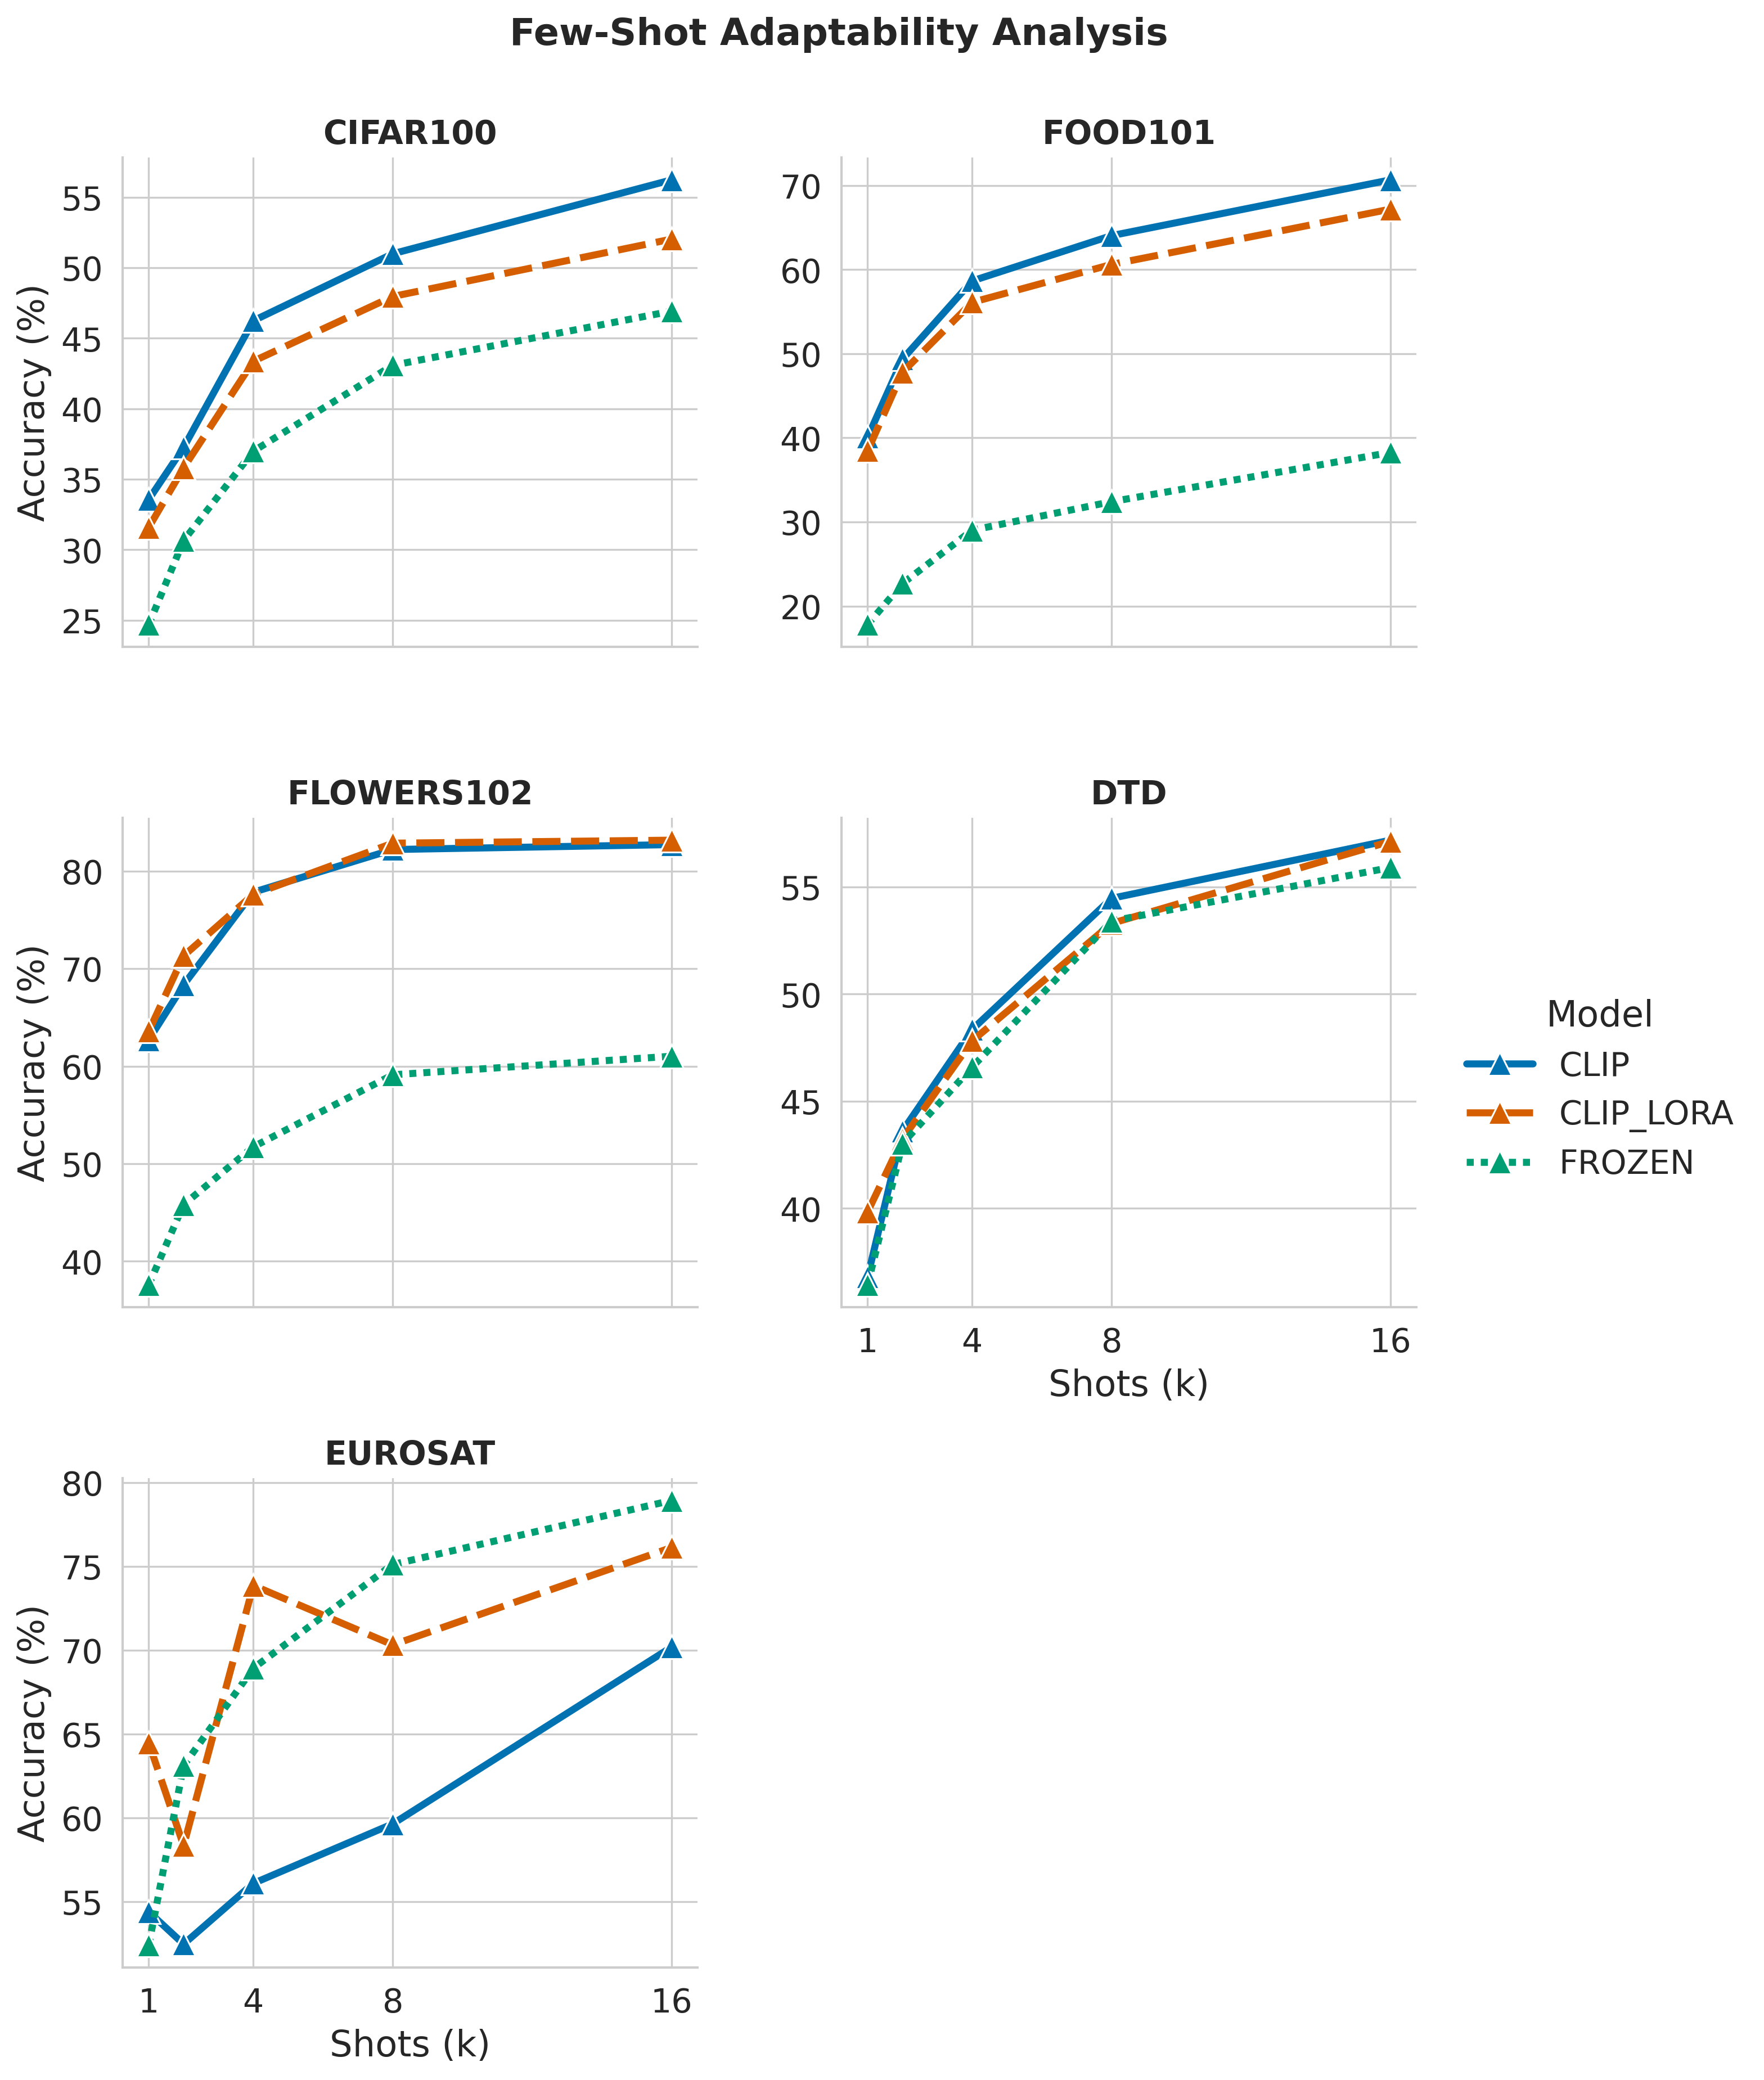

In [31]:
# def plot_few_shot_curves():
#     data = df[df["Task"] == "Few-Shot"]
#     if data.empty: return

#     g = sns.FacetGrid(data, col="Dataset", col_wrap=3, height=4, aspect=1.3, sharey=False)
    
#     g.map_dataframe(sns.lineplot, x="Shots", y="Accuracy", hue="Model", 
#                     style="Model", markers=MARKERS, palette=COLORS, 
#                     linewidth=3, markersize=10)
    
#     # Tweak Layout
#     g.set_titles(col_template="{col_name}", fontweight='bold', size=14)
#     g.set_axis_labels("Shots (k)", "Accuracy (%)")
#     g.set(xticks=[1, 4, 8, 16])
#     g.add_legend(title="Model", bbox_to_anchor=(1.02, 0.5))
    
#     plt.suptitle("Few-Shot Adaptability Analysis", y=1.05, fontweight='bold', size=16)
#     plt.savefig(OUTPUT_DIR / "Fig4_FewShot_Curves.png", bbox_inches='tight')
#     plt.show()

# plot_few_shot_curves()
def plot_few_shot_curves():
    data = df[df["Task"] == "Few-Shot"]
    if data.empty:
        return

    g = sns.FacetGrid(
        data,
        col="Dataset",
        col_wrap=2,          # ✅ centers last row (DTD & EuroSAT)
        height=4,
        aspect=1.1,          # ✅ slightly narrower plots
        sharey=False
    )

    g.map_dataframe(
        sns.lineplot,
        x="Shots",
        y="Accuracy",
        hue="Model",
        style="Model",
        markers=MARKERS,
        palette=COLORS,
        linewidth=3,
        markersize=10
    )

    # Layout tweaks
    g.set_titles(col_template="{col_name}", fontweight="bold", size=14)
    g.set_axis_labels("Shots (k)", "Accuracy (%)")
    g.set(xticks=[1, 4, 8, 16])

    g.add_legend(
        title="Model",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

    g.fig.subplots_adjust(wspace=0.25, hspace=0.35)

    plt.suptitle(
        "Few-Shot Adaptability Analysis",
        y=1.03,
        fontweight="bold",
        size=16
    )

    plt.savefig(
        OUTPUT_DIR / "Fig4_FewShot_Curves.png",
        bbox_inches="tight",
        dpi=300
    )
    plt.show()


plot_few_shot_curves()


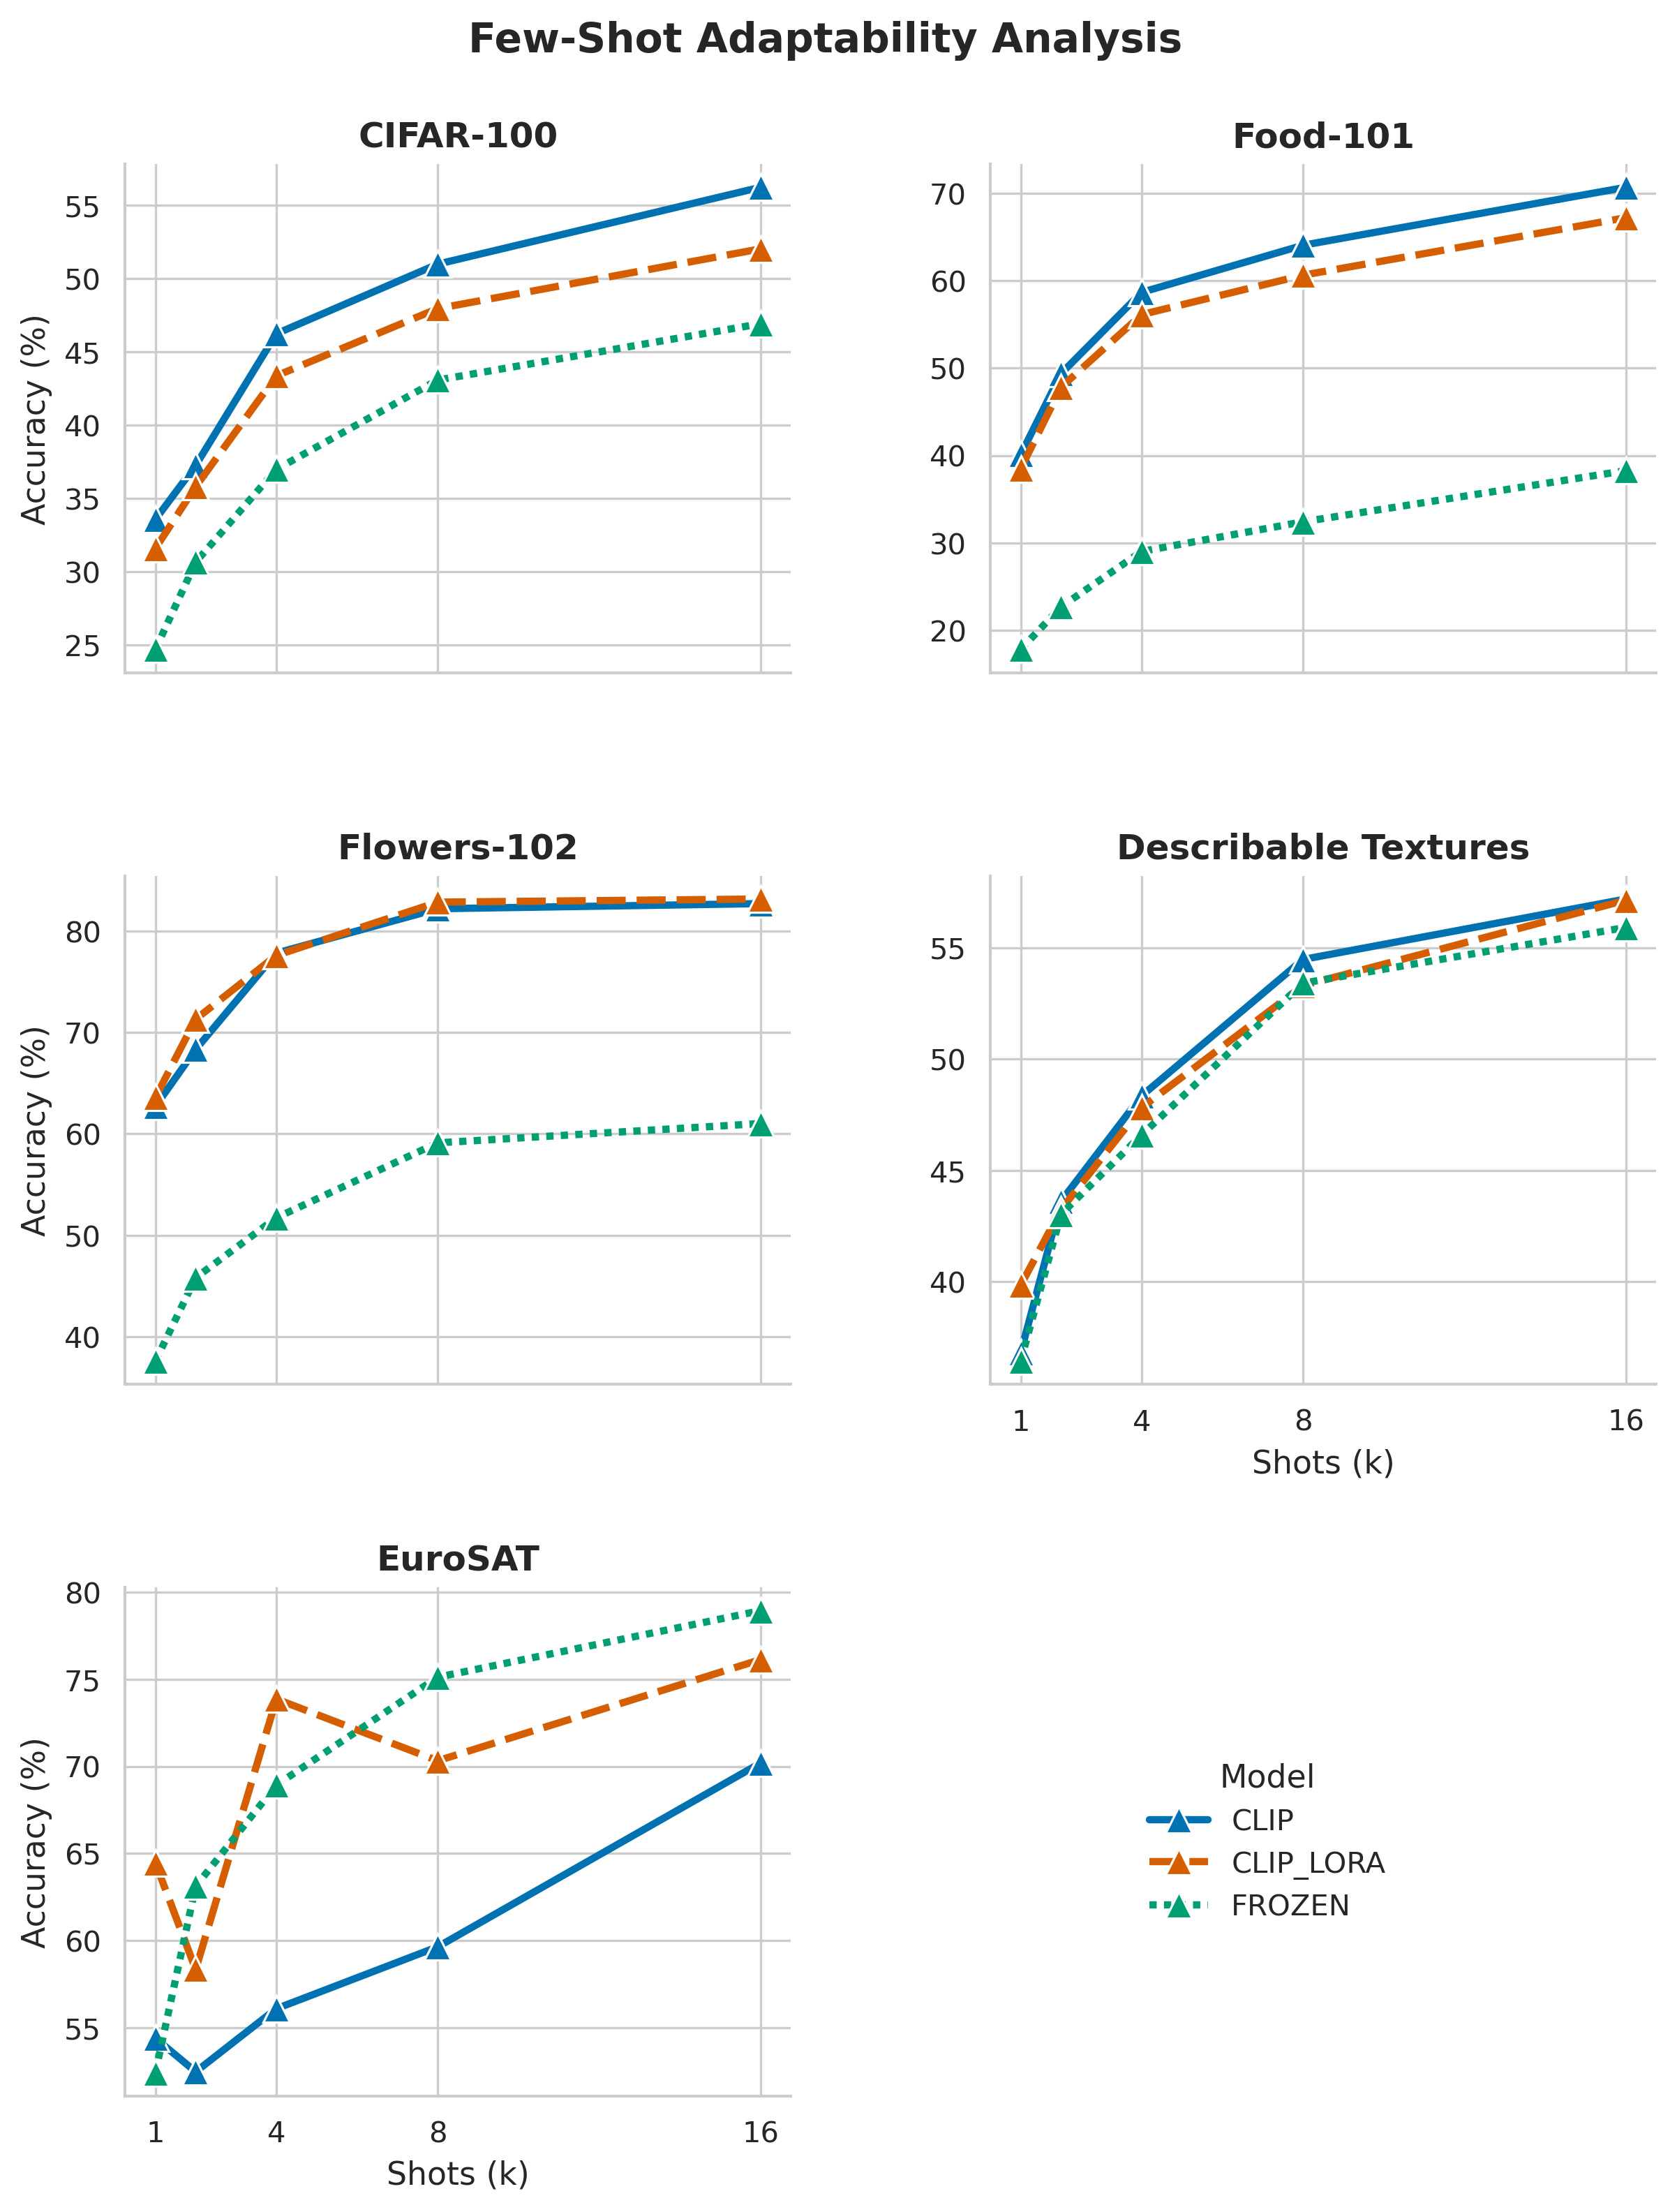

In [41]:
def plot_few_shot_curves():
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Create a copy to act on
    data = df[df["Task"] == "Few-Shot"].copy()
    if data.empty:
        return

    # 1. IEEE Standard Naming & Formatting
    name_mapping = {
        "CIFAR100": "CIFAR-100",
        "FOOD101": "Food-101",
        "FLOWERS102": "Flowers-102",
        "DTD": "Describable Textures", # Full form as requested
        "EUROSAT": "EuroSAT"
    }
    
    # Normalize names in dataframe
    # (Handles potentially different casing in raw data)
    data["Dataset"] = data["Dataset"].str.upper() # Ensure matching
    mapping_upper = {k.upper(): v for k, v in name_mapping.items()}
    data["Dataset"] = data["Dataset"].map(mapping_upper)

    # Define strict order
    dataset_order = [
        "CIFAR-100", 
        "Food-101", 
        "Flowers-102", 
        "Describable Textures", 
        "EuroSAT"
    ]
    
    # Filter valid data
    data = data[data["Dataset"].isin(dataset_order)]

    # 2. Plotting Structure
    g = sns.FacetGrid(
        data,
        col="Dataset",
        col_order=dataset_order,
        col_wrap=2,
        height=3.5,    # Slightly smaller height for Paper compactness
        aspect=1.2,
        sharey=False
    )

    g.map_dataframe(
        sns.lineplot,
        x="Shots",
        y="Accuracy",
        hue="Model",
        style="Model",
        markers=MARKERS,
        palette=COLORS,
        linewidth=2.5,  # Standard line width
        markersize=9
    )

    # ---- Clean up auto-legends ----
    for ax in g.axes.flatten():
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # ---- IEEE Style Formatting ----
    # Titles: Bold, slightly larger than axis text
    g.set_titles("{col_name}", fontweight="bold", size=12)
    
    # Axis Labels: Standard reading size
    g.set_axis_labels("Shots (k)", "Accuracy (%)", fontsize=11)
    
    # Ticks: Clear and legible
    g.set(xticks=[1, 4, 8, 16])
    for ax in g.axes.flatten():
        ax.tick_params(labelsize=10)

    # ---- Legend Placement ----
    # Grid Layout:
    # [0] CIFAR       [1] Food
    # [2] Flowers     [3] Textures
    # [4] EuroSAT     [5] <EMPTY SLOT>
    
    # We place the legend in the <EMPTY SLOT> (Bottom Right).
    # We anchor it to the EuroSAT plot (axes[4]) and move it right.
    
    last_ax = g.axes[4] # EuroSAT
    handles, labels = last_ax.get_legend_handles_labels()

    legend = last_ax.legend(
        handles,
        labels,
        title="Model",
        loc="center left",
        bbox_to_anchor=(1.5, 0.5), # Moves legend into the empty right column
        frameon=False,
        fontsize=10,
        title_fontsize=11
    )

    # Adjust spacing to prevent overlap
    g.fig.subplots_adjust(wspace=0.3, hspace=0.4)

    plt.suptitle(
        "Few-Shot Adaptability Analysis",
        y=1.02,
        fontsize=14,
        fontweight="bold"
    )

    plt.savefig(
        OUTPUT_DIR / "Fig4_FewShot_Curves.png",
        bbox_inches="tight",
        dpi=300
    )

    plt.show()

plot_few_shot_curves()